# Import useful packages.

In [1]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 9.9 MB/s 


In [2]:
from tensorflow import keras
import tensorflow as tf
import tensorflow.keras.layers as Layers
import tensorflow.keras.activations as Actications
import tensorflow.keras.models as Models
import tensorflow.keras.optimizers as Optimizer
import tensorflow.keras.metrics as Metrics
import tensorflow.keras.utils as Utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import TensorBoard
import tensorflow_addons as tfa
import os
import random
import datetime
import cv2
import numpy as np
from sklearn.utils import shuffle
# from sklearn.metrics import confusion_matrix as CM
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plot
import seaborn as sn

In [4]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8529276223013866185
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14465892352
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 9288645121893366853
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

# Drive

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp drive/MyDrive/image-classification.zip .
!unzip image-classification.zip -d ./data
!rm image-classification.zip
# or download from keras
# kaggle datasets download -d puneet6060/intel-image-classification

# Load the data.

In [7]:
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
class_names_label = {'buildings': 0,
                    'forest' : 1,
                    'glacier' : 2,
                    'mountain' : 3,
                    'sea' : 4,
                    'street' : 5
                    }
nb_classes = 6

In [8]:
IMG_SZ = (150, 150)
BATCH_SZ = 32


def load_data(data_directories,
              target_size=(150, 150),
              seed=8,
              class_mode='categorical',
              batch_size=32,
              **kwargs):
    """
        Load the data:
            - 14,034 images to train the network.
            - 3000 images to evaluate how accurately the network learned to classify images.
        Input:
            Data directory.
        Return: 
            training_set, testing_set.
    """
    train_generator = ImageDataGenerator(rescale=1./255,
                                         shear_range=0.2,
                                         zoom_range=0.2,
                                         )
    test_generator = ImageDataGenerator(rescale=1./255)
    training_set = train_generator.flow_from_directory(data_directories[0],
                                                       target_size=target_size,
                                                       shuffle=True,
                                                       seed=seed,
                                                       class_mode=class_mode,
                                                       batch_size=batch_size,
                                                       **kwargs)
    testing_set = test_generator.flow_from_directory(data_directories[1],
                                                     target_size=target_size,
                                                     shuffle=False,
                                                     seed=seed,
                                                     class_mode=class_mode,
                                                     batch_size=batch_size,
                                                     **kwargs)
    return training_set, testing_set


data_directories = ['data/seg_train/seg_train/', 'data/seg_test/seg_test/']
train_dataset, test_dataset = load_data(data_directories,
                                        target_size=IMG_SZ,
                                        seed=8,
                                        class_mode='categorical',
                                        batch_size=BATCH_SZ)


Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


### Google drive upload

## Explore the dataset.

In [9]:
print('Number of training examples:',train_dataset.n)
print('Number of testing examples:',test_dataset.n)
print('Each image is size of:', train_dataset.image_shape)

Number of training examples: 14034
Number of testing examples: 3000
Each image is size of: (150, 150, 3)


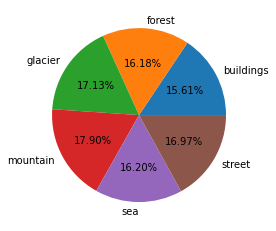

In [10]:
from collections import Counter
def plot_pie(train_dataset, class_names):
    data = dict(Counter(train_dataset.classes))
    plot.pie(data.values(), labels=train_dataset.class_indices, autopct='%.2f%%')
    plot.show()

plot_pie(train_dataset, class_names)

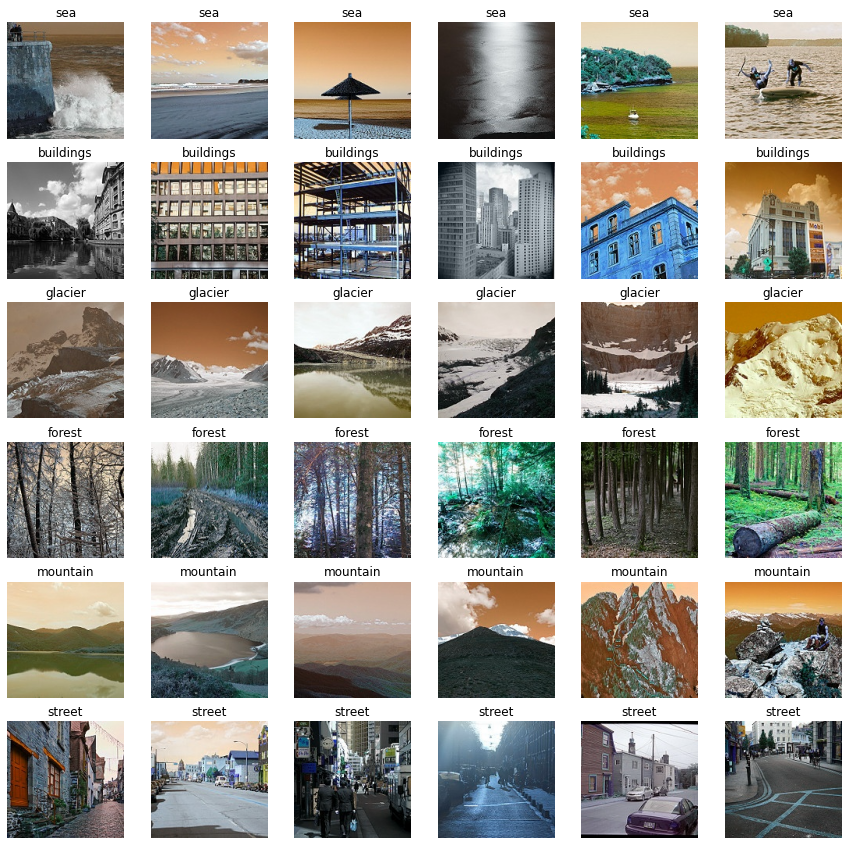

In [11]:
def visualize_image(train_directory):
  plot.figure(figsize=(15,15))
  list_folders = os.listdir(train_directory)
  for i, folder in enumerate(list_folders):
    random_images=np.random.choice(os.listdir(os.path.join(train_directory,folder)),size=6)
    for j, filename in enumerate(random_images):
      img = cv2.imread(os.path.join(train_directory,folder,filename))
      img = np.asarray(img)
      plot.subplot(6,6,i*6 + (j+1))
      plot.imshow(img)
      plot.title(folder)
      plot.axis('off')
  plot.show()

train_directory = 'data/seg_train/seg_train/'
visualize_image(train_directory)

# Modelling


## Build the model

In [12]:
def get_batch_norm_layer(momentum=0.95, epsilon=0.005, beta_initializer='normal', gamma_value=0.9, **kwarg):
  if beta_initializer == 'normal':
    beta_initializer_ = keras.initializers.RandomNormal(mean=0., stddev=0.01)
  else:
    raise ValueError('Do not support other initializer')
  return keras.layers.BatchNormalization(momentum=momentum, 
                                        epsilon=epsilon,
                                        beta_initializer = beta_initializer_,
                                        gamma_initializer = keras.initializers.Constant(value=gamma_value),
                                        **kwarg)
def create_model():
  '''
  Return: 
      CNN model with 13 layers.
  '''
  
  model = keras.Sequential([
    keras.Input(shape=IMG_SZ + (3,)),
    keras.layers.Conv2D(8, kernel_size=(3,3), activation='relu', padding='same'),
    get_batch_norm_layer(),
    keras.layers.Conv2D(16, kernel_size=(3,3), activation='relu', padding='same'),
    get_batch_norm_layer(),
    keras.layers.MaxPool2D(2),
    keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'),
    get_batch_norm_layer(),
    keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'),
    get_batch_norm_layer(),
    keras.layers.MaxPool2D(3),
    keras.layers.Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'),
    get_batch_norm_layer(),
    keras.layers.Conv2D(256, kernel_size=(3,3), activation='relu', padding='same'),
    get_batch_norm_layer(),
    keras.layers.MaxPool2D(5),
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation='relu'),
    get_batch_norm_layer(),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(nb_classes, activation='softmax'),
  ])

  return model
model = create_model()

In [13]:
def get_f1_metric(*args, num_classes=6, name='f1_score', average='macro',**kwargs):
  return tfa.metrics.F1Score(*args,
                              num_classes=num_classes,
                              name=name,
                              average=average,
                              **kwargs)

def optimize(model):
    '''
    Input: 
        Model.
    Return: 
        Complied model.
    '''
    model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.Adam(learning_rate=0.0001),
                  metrics=['accuracy', get_f1_metric()])
    return model

model = optimize(model)
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 8)       224       
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 8)      32        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 16)      1168      
                                                                 
 batch_normalization_1 (Batc  (None, 150, 150, 16)     64        
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 16)       0         
 )                                                               
                                                        

In [14]:
def callback_model(checkpoint_name, logs_name):
    '''
    Input: 
        Best checkpoint name, logs name.
    Return: 
        Callback list, which contains tensorboard callback and checkpoint callback.
    '''
    callbacks_list = [keras.callbacks.ModelCheckpoint(checkpoint_name,
                                                      save_best_only=True,
                                                      save_freq='epoch',
                                                      monitor='val_f1_score',
                                                      mode='max',
                                                      verbose=1),
                      keras.callbacks.ReduceLROnPlateau(monitor='val_f1_score',
                                                        mode='max',
                                                        factor=0.1,
                                                        patience=2),
                      keras.callbacks.TensorBoard(log_dir=logs_name)]
    return callbacks_list

checkpoint_name = 'weights.best.hdf5'
logs_name = 'training_logs'
callbacks_list = callback_model(checkpoint_name, logs_name)

In [15]:
# Train model
model.fit(train_dataset,
            epochs=10,
            validation_data=test_dataset,
            batch_size=BATCH_SZ,
            callbacks=callbacks_list,)
model = load_model(checkpoint_name)


Epoch 1/10
439/439 [==============================] - ETA: 0s - loss: 1.0251 - accuracy: 0.6293 - f1_score: 0.6256
Epoch 1: val_f1_score improved from -inf to 0.74017, saving model to weights.best.hdf5
439/439 [==============================] - 102s 202ms/step - loss: 1.0251 - accuracy: 0.6293 - f1_score: 0.6256 - val_loss: 0.7568 - val_accuracy: 0.7413 - val_f1_score: 0.7402 - lr: 1.0000e-04
Epoch 2/10
439/439 [==============================] - ETA: 0s - loss: 0.7345 - accuracy: 0.7339 - f1_score: 0.7341
Epoch 2: val_f1_score improved from 0.74017 to 0.79866, saving model to weights.best.hdf5
439/439 [==============================] - 88s 201ms/step - loss: 0.7345 - accuracy: 0.7339 - f1_score: 0.7341 - val_loss: 0.5976 - val_accuracy: 0.7993 - val_f1_score: 0.7987 - lr: 1.0000e-04
Epoch 3/10
439/439 [==============================] - ETA: 0s - loss: 0.6214 - accuracy: 0.7793 - f1_score: 0.7799
Epoch 3: val_f1_score improved from 0.79866 to 0.80472, saving model to weights.best.hdf5
4

In [17]:
# Evaluate model
from tensorflow.keras.utils import to_categorical
def get_prediction_classes(model, prediction_dataset):
    '''
    Input: 
        Model and prediction dataset.
    Return: 
        Prediction list and groundtrurth list with predicted classes.
    '''
    y_pred = model.predict(prediction_dataset)

    for metric in model.metrics:
      if 'f1_score' == metric.name:
        break
    assert metric.name == 'f1_score', 'There is no metric name f1_score'
    metric.update_state(to_categorical(prediction_dataset.classes), y_pred)
    print('F1 score:',metric.result().numpy())
    
    return y_pred.argmax(axis=1), prediction_dataset.classes

test_predictions, test_groundtruths = get_prediction_classes(model, test_dataset)
    

F1 score: 0.8564422


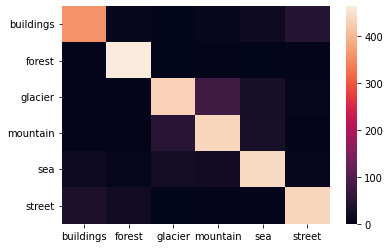

In [18]:
def plot_confusion_matrix(predictions, groundtruth, class_names):
  matrix = confusion_matrix(groundtruth, predictions)
  ax = sn.heatmap(matrix, xticklabels=class_names, yticklabels=class_names)
  plot.show()
plot_confusion_matrix(test_predictions, test_groundtruths, class_names)

## Fine tuning

In [19]:
data_paths = {'train': 'data/seg_train/seg_train',
              'test': 'data/seg_test/seg_test'}

In [20]:
# Data generator
aug_params = dict(rotation_range=0.2,
                  width_shift_range=0.1,
                  height_shift_range=0.1,
                  shear_range=0.2,
                  zoom_range=0.2,
                  horizontal_flip=True)
train_generator = ImageDataGenerator(rescale=1./255,
                                     **aug_params)
train_data = train_generator.flow_from_directory(data_paths['train'],
                                                 target_size=IMG_SZ,
                                                 shuffle=True,
                                                 seed=8,
                                                 class_mode='categorical',
                                                 batch_size=BATCH_SZ)

test_generator = ImageDataGenerator(rescale=1./255)
test_data = test_generator.flow_from_directory(data_paths['test'],
                                               target_size=IMG_SZ,
                                               shuffle=False,
                                               seed=8,
                                               class_mode='categorical',
                                               batch_size=BATCH_SZ)

train_noaug_data = test_generator.flow_from_directory(data_paths['train'],
                                                      target_size=IMG_SZ,
                                                      shuffle=False,
                                                      seed=8,
                                                      class_mode='categorical',
                                                      batch_size=BATCH_SZ)


Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Found 14034 images belonging to 6 classes.


data/seg_train/seg_train/glacier/17697.jpg


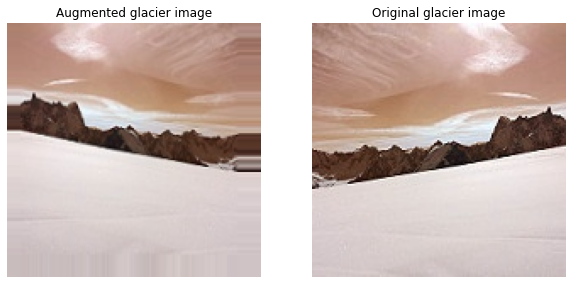

In [22]:
def view_random_aug_image(data_gen, path, file_fmt = 'jpg'):
    while os.path.isdir(path):
        path = os.path.join(path,np.random.choice(os.listdir(path)))
    print(path)
    img = np.asarray(cv2.imread(path))
    img = np.expand_dims(img, axis=0)
    data_gen.fit(img)
    label = path.split('/')[-2]
    label_idx = class_names_label[label]
    aug_img = data_gen.flow(img, np.array([label_idx]), batch_size=1, shuffle=False)[0][0][0]
    plot.figure(figsize=(10, 5))
    plot.subplot(1,2,1)
    plot.imshow(aug_img)
    plot.title(f'Augmented {label} image')
    plot.axis('off')
    plot.subplot(1,2,2)
    plot.imshow(img[0])
    plot.title(f'Original {label} image')
    plot.axis('off')    
view_random_aug_image(train_generator,data_paths['train'])

In [23]:
model = load_model('weights.best.hdf5')

In [ ]:
callbacks_list = callback_model('finetuning.hdf5', 'finetuning_logs')
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(1e-5),
              metrics=['acc', get_f1_metric()])
model.fit(train_data,
          epochs=10,
          validation_data=test_data,
          batch_size=BATCH_SZ,
          callbacks=callbacks_list)


In [25]:
model = load_model('finetuning.hdf5')
test_predictions, test_groundtruths = get_prediction_classes(model, test_dataset)

F1 score: 0.86327696


## Adjust architecture

In [38]:
BATCH_SZ = 128

In [44]:
train_data.batch_size = BATCH_SZ
test_data.batch_size = BATCH_SZ

In [50]:
def create_model():
  '''
  '''
  model = keras.Sequential([
    keras.Input(shape=IMG_SZ + (3,)),
    keras.layers.Conv2D(8, kernel_size=(3,3), activation='relu', padding='same'),
    get_batch_norm_layer(),
    keras.layers.Conv2D(16, kernel_size=(3,3), activation='relu', padding='same'),
    get_batch_norm_layer(),
    keras.layers.MaxPool2D(2),
    keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'),
    get_batch_norm_layer(),
    keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'),
    get_batch_norm_layer(),
    keras.layers.MaxPool2D(3),
    keras.layers.Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'),
    get_batch_norm_layer(),
    keras.layers.Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'),
    get_batch_norm_layer(),
    keras.layers.MaxPool2D(3),
    keras.layers.Flatten(),
    keras.layers.Dense(50, activation='relu'),
    get_batch_norm_layer(),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(nb_classes, activation='softmax'),
  ])

  return model
model = create_model()

In [51]:
# callbacks_list = callback_model('simpler_model.hdf5', 'simpler_model_logs')
callbacks_list = [keras.callbacks.ModelCheckpoint('simpler_model.hdf5',
                                                  save_best_only=True,
                                                  save_freq='epoch',
                                                  monitor='val_f1_score',
                                                  mode='max',
                                                  verbose=1),
                  keras.callbacks.LearningRateScheduler(lambda epoch, lr: lr/np.sqrt(epoch+1)),
                  keras.callbacks.TensorBoard(log_dir='simpler_model_logs')]

    
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(1e-3),
              metrics=['acc', get_f1_metric()])

In [ ]:
history = model.fit(train_data,
                    epochs=20,
                    validation_data=test_data,
                    batch_size = BATCH_SZ,
                    callbacks=callbacks_list)

In [53]:
model = load_model('simpler_model.hdf5')

In [54]:
print('Train')
test_predictions, test_groundtruths = get_prediction_classes(model, train_noaug_data)
print('Test')
test_predictions, test_groundtruths = get_prediction_classes(model, test_data)

Train
F1 score: 0.85514134
Test
F1 score: 0.8534363


## Transfer learning

### Dataset

In [55]:
train_generator = ImageDataGenerator(**aug_params)
train_data = train_generator.flow_from_directory(data_paths['train'],
                                                target_size=IMG_SZ,
                                                shuffle=True,
                                                seed=8,
                                                class_mode='categorical',
                                                batch_size=BATCH_SZ)

test_generator = ImageDataGenerator()
test_data = test_generator.flow_from_directory(data_paths['test'],
                                            target_size=IMG_SZ,
                                            shuffle=False,
                                            class_mode='categorical',
                                            batch_size=BATCH_SZ)

train_noaug_data = test_generator.flow_from_directory(data_paths['train'],
                                                    target_size=IMG_SZ,
                                                    shuffle=False,
                                                    class_mode='categorical',
                                                    batch_size=BATCH_SZ)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Found 14034 images belonging to 6 classes.


### Model

In [61]:
eff_b0 = keras.applications.EfficientNetB0(include_top=False, 
                                             weights='imagenet', 
                                             input_shape=IMG_SZ + (3,), 
                                             classes=nb_classes)
# Freezing all layers except 10 last layers
eff_b0.trainable = False
for layer in eff_b0.layers[-10:]:
  layer.trainable = True

In [62]:
# Build model
input_layer = keras.Input(shape=IMG_SZ + (3,))
x = eff_b0(input_layer)
x = keras.layers.GlobalAveragePooling2D()(x)
output = keras.layers.Dense(nb_classes, activation='softmax')(x)
model_b0 = keras.Model(inputs=input_layer, outputs=output)

In [64]:
# Callbacks
callbacks_list = callback_model('transfer_b0.hdf5', 'transfer_b0_logs')
# Compile
model_b0.compile(loss='categorical_crossentropy',
                 optimizer = keras.optimizers.Adam(learning_rate=1e-3),
                 metrics=['acc', get_f1_metric()])
                 

In [ ]:
# Training
model_b0.fit(train_data,
              epochs=10,
              validation_data=test_data,
              batch_size=BATCH_SZ,
              callbacks=callbacks_list,
              verbose=2)

In [ ]:
model_b0 = load_model('transfer_b0.hdf5')

In [67]:
model_b0.evaluate(test_data, batch_size=BATCH_SZ)

24/24 [==============================] - 6s 171ms/step - loss: 0.2266 - acc: 0.9187 - f1_score: 0.9208


[0.22663922607898712, 0.918666660785675, 0.9207941889762878]

In [68]:
model_b0.evaluate(train_noaug_data)

110/110 [==============================] - 18s 166ms/step - loss: 0.1869 - acc: 0.9318 - f1_score: 0.9334


[0.18689726293087006, 0.9318084716796875, 0.9333632588386536]

### Error analysis

In [69]:
import pandas as pd

In [70]:
def get_top_wrong_prediction(dataset, model=None, y_pred=None, topk=10, visualize=False):
    """return  a pandas data frame of top k most wrong predictions"""

    df = pd.DataFrame()
    assert type(model) != type(None) or type(y_pred) != type(None), 'Model or y_pred must be spectified'
    # Get predictions
    if type(y_pred) == type(None):
        y_pred = (model.predict(dataset))
    df['pred_prob'] = y_pred.max(axis=1)
    df['pred_class'] = y_pred.argmax(axis=1)
    df['true'] = dataset.labels
    df['filename'] = dataset.filepaths
    df['correct'] = df['pred_class'] == df['true']

    # Get wrong predictions
    df_wrong = df[~df['correct']].copy()
    df_wrong.sort_values('pred_prob', ascending=False, inplace=True)

    # Get the top k most wrong predictions
    topk = min(df_wrong.shape[0], topk)
    print(f'Getting the top {topk} most wrong predictions')
    df_topk = df_wrong.head(topk)
    df_topk.reset_index(inplace=True)

    # Visualize
    if visualize and topk > 20:
        input_ = input(f'Are you sure that you want to visualize {topk} images? yes/no')
        if input_ == 'yes':
            visualize = True
        else:
            visualize = False
    if visualize:
        n_cols = 5
        n_rows = topk//n_cols + bool(topk%n_cols)
        plot.figure(figsize=(20,n_rows*5))
        for i in range(topk):
            idx, pred_prob, pred_class, true_class, filename, _ = df_topk.loc[i]
            img = np.asarray(cv2.imread(filename))
            plot.subplot(n_rows, n_cols, i+1)
            plot.imshow(img)
            plot.axis('off')
            plot.title(f'''Prediction: {class_names[pred_class]} with {pred_prob*100:.1f}% conf
            True label: {class_names[true_class]}''')
    return df_topk

def most_freq_value(row):
    return row.mode()

#### Train

Getting the top 20 most wrong predictions


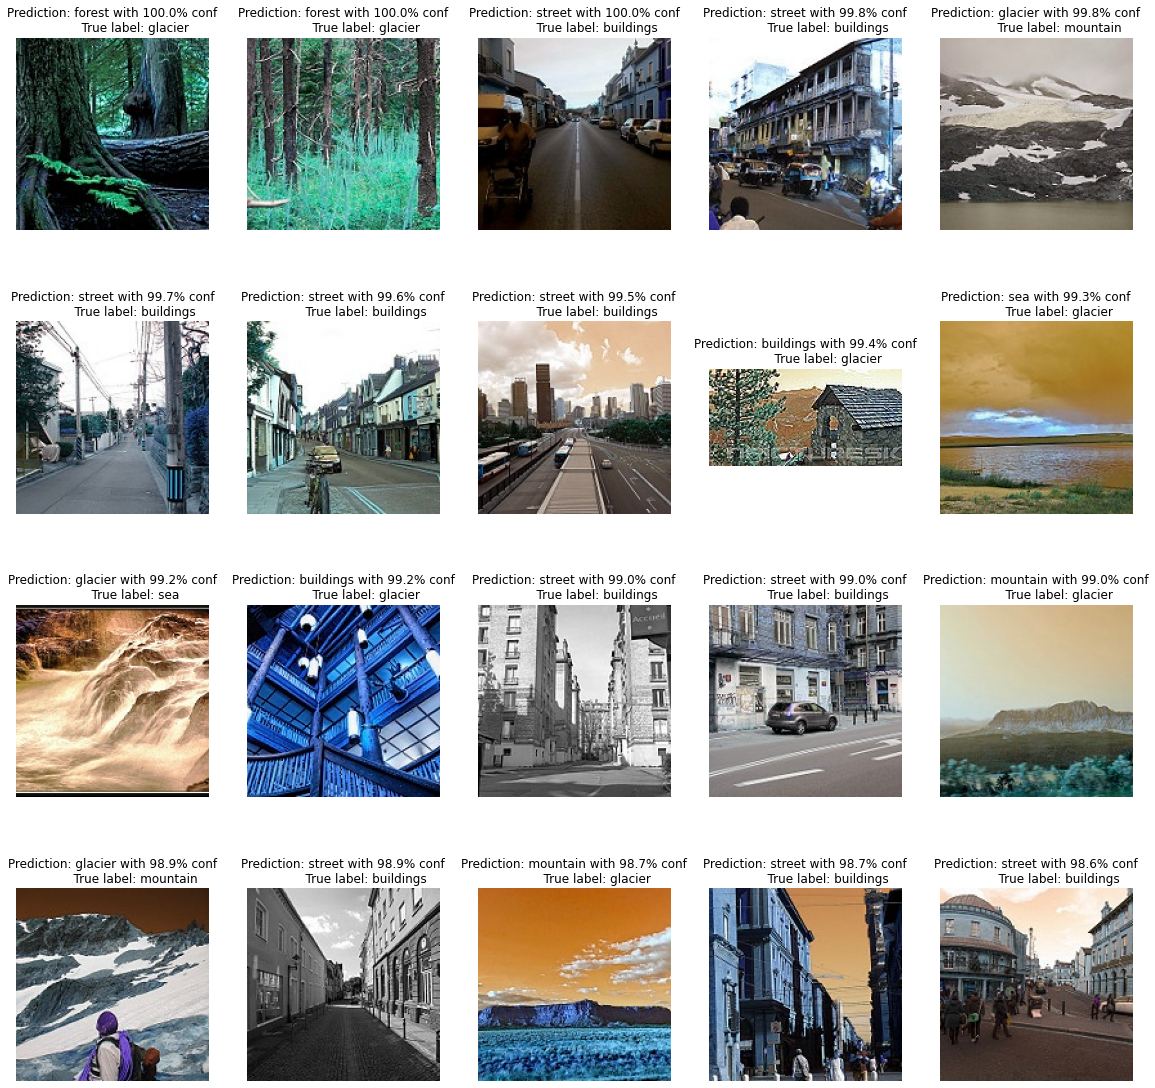

In [71]:
y_pred = model_b0.predict(train_noaug_data)
df_wrong = get_top_wrong_prediction(train_noaug_data, y_pred=y_pred, topk=20, visualize=True)

In [72]:
df_wrong = get_top_wrong_prediction(train_noaug_data, y_pred=y_pred, topk=len(train_noaug_data)*BATCH_SZ, visualize=False)
df_wrong.groupby('true').agg({'true':'count','pred_class': most_freq_value})

Getting the top 957 most wrong predictions


true  pred_class
true                  
0      153           5
1       18           3
2      304           3
3      315           2
4       88           3
5       79           0

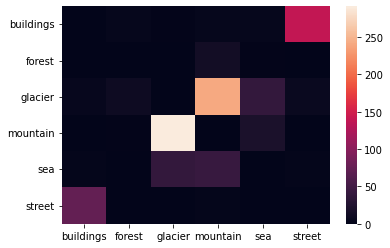

In [73]:
plot_confusion_matrix(df_wrong['pred_class'], df_wrong['true'], class_names)

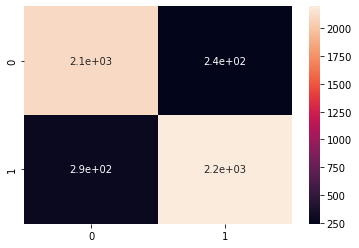

In [74]:
mountain_glacier_matrix_train = confusion_matrix(train_noaug_data.labels, y_pred.argmax(axis=1))[2:4, 2:4]
sn.heatmap(mountain_glacier_matrix_train, annot=True)

In [75]:
mountain_glacier_acc_train = (mountain_glacier_matrix_train[0,0] + mountain_glacier_matrix_train[1,1]) / (mountain_glacier_matrix_train.sum(axis=None))
mountain_glacier_acc_train

0.889648033126294

#### Test

In [104]:
y_pred = model_b0.predict(test_data)
df_wrong = get_top_wrong_prediction(test_data, y_pred=y_pred, topk=len(test_data)*BATCH_SZ, visualize=False)
df_wrong.groupby('true').agg({'true':'count','pred_class': most_freq_value})

Getting the top 244 most wrong predictions


true  pred_class
true                  
0       40           5
1        3           2
2       79           3
3       72           2
4       24           2
5       26           0

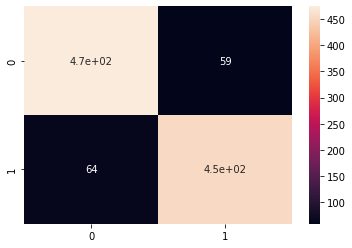

In [77]:
mountain_glacier_matrix_test = confusion_matrix(test_data.labels, y_pred.argmax(axis=1))[2:4, 2:4]
sn.heatmap(mountain_glacier_matrix_test, annot=True)

In [78]:
mountain_glacier_acc_test = (mountain_glacier_matrix_test[0,0] + mountain_glacier_matrix_test[1,1]) / (mountain_glacier_matrix_test.sum(axis=None))
mountain_glacier_acc_test

0.8828571428571429

Getting the top 20 most wrong predictions


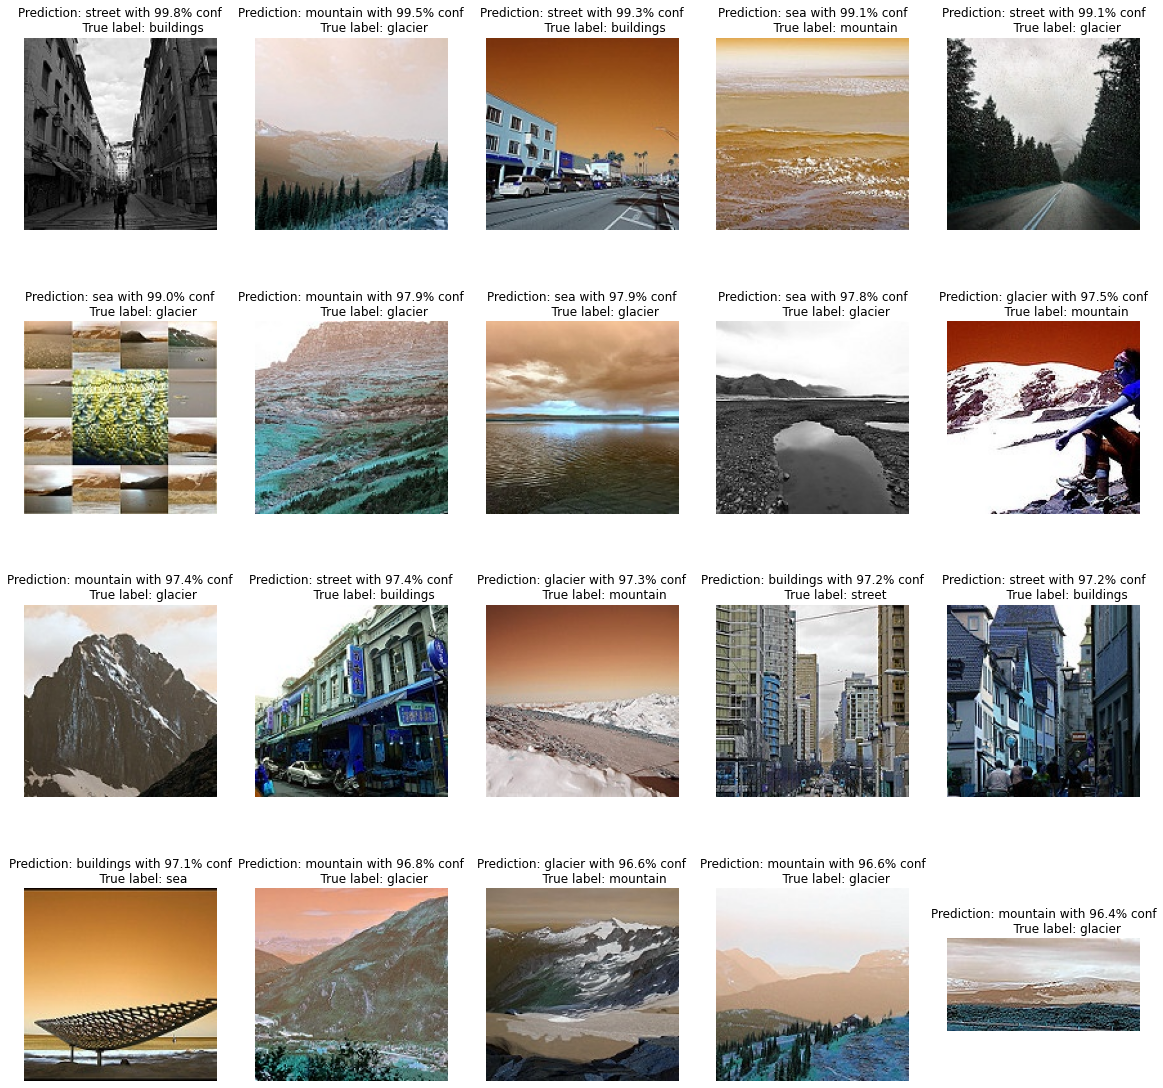

In [106]:
df_wrong = get_top_wrong_prediction(test_data, y_pred=y_pred, topk=20, visualize=True)

## Mountain/Glacier classification

### Dataset

In [79]:
mapping_class_name = dict([[value, key] for key, value in class_names_label.items()])
df_train_generator = pd.DataFrame()
df_train_generator['filepath'] = train_noaug_data.filepaths
df_train_generator['class_idx'] = train_noaug_data.labels
df_train_generator['class_name'] = df_train_generator['class_idx'].map(mapping_class_name)
df_train_mountain_glacier = df_train_generator[(df_train_generator['class_idx'] == class_names_label['mountain']) | (df_train_generator['class_idx'] == class_names_label['glacier'])]

df_test_generator = pd.DataFrame()
df_test_generator['filepath'] = test_data.filepaths
df_test_generator['class_idx'] = test_data.labels
df_test_generator['class_name'] = df_test_generator['class_idx'].map(mapping_class_name)
df_test_mountain_glacier = df_test_generator[(df_test_generator['class_idx'] == class_names_label['mountain']) | (df_test_generator['class_idx'] == class_names_label['glacier'])]

In [80]:
train_mountain_glacier_generator = ImageDataGenerator(**aug_params)
train_mountain_glacier_data = train_mountain_glacier_generator.flow_from_dataframe(
    dataframe = df_train_mountain_glacier,
    x_col = 'filepath',
    y_col = 'class_name',
    class_mode = 'binary',
    batch_size = BATCH_SZ,
    shuffle= True,
    seed = 8
)

test_mountain_glacier_generator = ImageDataGenerator()
test_mountain_glacier_data = test_mountain_glacier_generator.flow_from_dataframe(
    dataframe = df_test_mountain_glacier,
    x_col = 'filepath',
    y_col = 'class_name',
    class_mode = 'binary',
    batch_size = BATCH_SZ,
    shuffle= False
)

Found 4916 validated image filenames belonging to 2 classes.
Found 1078 validated image filenames belonging to 2 classes.


In [81]:
train_mountain_glacier_data.class_indices

{'glacier': 0, 'mountain': 1}

### Model

In [111]:
eff2_b0 = keras.applications.EfficientNetB0(include_top=False, 
                                            weights='imagenet', 
                                            input_shape=IMG_SZ + (3,), 
                                            classes=2,
                                            classifier_activation="sigmoid")
# Freezing all layers except 10 last layers
eff2_b0.trainable = False
for layer in eff2_b0.layers[-15:]:
  layer.trainable = True

In [112]:
# Build model
input_layer = keras.Input(shape=IMG_SZ + (3,))
x = eff2_b0(input_layer)
x = keras.layers.GlobalAveragePooling2D()(x)
output = keras.layers.Dense(1, activation='sigmoid')(x)
model_mountain_glacier = keras.Model(inputs=input_layer, outputs=output)

In [113]:
# Callbacks
callbacks_list = callback_model('mountain_glacier_transfer_b0.hdf5', 'mountain_glacier_transfer_b0_logs')
# Compile
model_mountain_glacier.compile(loss='binary_crossentropy',
                 optimizer = keras.optimizers.Adam(learning_rate=1e-4),
                 metrics=['acc', get_f1_metric(num_classes=1, threshold=0.5)])

In [ ]:
model_mountain_glacier.fit(train_mountain_glacier_data,
                        epochs=15,
                        validation_data=test_mountain_glacier_data,
                        batch_size=BATCH_SZ,
                        callbacks=callbacks_list,
                        verbose=2)

In [ ]:
model_mountain_glacier = load_model('mountain_glacier_transfer_b0.hdf5')

In [ ]:
model_mountain_glacier.evaluate(test_mountain_glacier_data)

## Combine two models

In [99]:
class_index_convertor = np.array([class_names_label['glacier'], class_names_label['mountain']])
def ensemble_predict(six_classes_model, two_classes_model, dataset, class_index_convertor):
    """
    Note: non shuffle dataset
    """
    y6_pred = six_classes_model.predict(dataset)
    y2_pred = two_classes_model.predict(dataset)

    y6_pred_class = y6_pred.argmax(axis = 1)
    y2_pred_class = y2_pred > 0.5
    # print(y2_pred_class)
    y2_pred_class_convert = class_index_convertor[y2_pred_class.flatten().astype(np.int32)]
    building_street_idx = (y6_pred_class == class_names_label['mountain']) | (y6_pred_class == class_names_label['glacier'])
    
    y6_pred_class[building_street_idx] = y2_pred_class_convert[building_street_idx]

    return y6_pred_class

In [100]:
y_pred = ensemble_predict(model_b0, model_mountain_glacier, test_data, class_index_convertor)
accuracy_score(test_data.labels, y_pred)

0.9083333333333333

In [91]:
import sklearn.metrics
sklearn.metrics.f1_score(test_data.labels, y_pred, average='macro')

0.9087051184630731